In [35]:
# import os
import cv2
import numpy as np
# import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
# import matplotlib.pyplot as plt
# import plotly.express as px

# from PIL import Image
# from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten

import xml.etree.ElementTree as ET
import pandas as pd

In [36]:
xml_example = 'training_images/training_images/cucumber_1.xml'

with open(xml_example, 'r') as f:
    data = f.read()
    content = BeautifulSoup(data, 'xml')
content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single cucumber</folder>
<filename>cucumber_1.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single cucumber\cucumber_1.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>cucumber</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>23</xmin>
<ymin>42</ymin>
<xmax>206</xmax>
<ymax>199</ymax>
</bndbox>
</object>
</annotation>

In [37]:
path = sorted(glob('training_images/training_images/*.xml'))# get all elements in path with xml extension
y = [] #create a list to store our targets
for file in path:# loop over each file path and parse it
    label = 0
    info = xt.parse(file) 
    root = info.getroot() 
    obj = root.find('object')
    
    label_obj = (obj.find('name').text)
    if "cucumber" in label_obj:  
        label = 1
    elif "eggplant" in label_obj:
        label = 2
    elif "mushroom" in label_obj:
        label = 3

    bndbox = obj.find('bndbox')
    xmin = (bndbox.find('xmin').text)
    xmax = (bndbox.find('xmax').text)
    ymin = (bndbox.find('ymin').text)
    ymax = (bndbox.find('ymax').text)
    
    #append the results to our target
    y.append([int(label),int(xmin),int(ymin),int(xmax),int(ymax)])

In [38]:
y[0]

[1, 23, 42, 206, 199]

In [39]:
# X = []
# images_path = sorted(glob('training_images/training_images/*.jpg'))# get all elements in path with jpg extension

# for image in images_path:#loop over image path
#     img = cv2.imread(image, cv2.COLOR_BGR2RGB)# read the image in rgb mode
#     X.append(img)
import cv2
from glob import glob

X = []
images_path = sorted(glob('training_images/training_images/*.jpg'))  # Get all images in the directory

for image in images_path:
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode
    X.append(img)

In [40]:
X[0].shape

(227, 227)

In [41]:
X = np.expand_dims(X, axis=-1)

In [42]:
img = X[0]
bbox = y[0][1:]
y[1][1:] #view the bbox coordinates

[13, 70, 219, 160]

In [43]:
print(type(img))
print(img.shape)
print(img.min(), img.max())

<class 'numpy.ndarray'>
(227, 227, 1)
45 255


In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


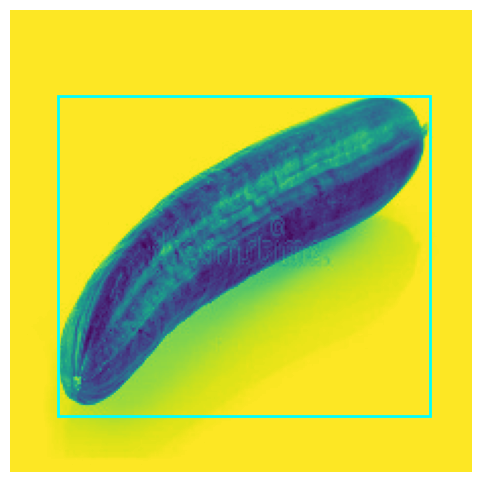

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
rect = patches.Rectangle(
    (bbox[0], bbox[1]),           # Bottom-left corner
    bbox[2] - bbox[0],            # Width
    bbox[3] - bbox[1],            # Height
    linewidth=2, edgecolor='cyan', facecolor='none'
)
ax.add_patch(rect)

# Remove axis and display
ax.axis('off')
plt.show()

In [46]:
X = np.array(X)
y =  np.array(y)

In [47]:
# X

In [48]:
# y

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)


In [50]:

categ_train = y_train[:,0:1]
categ_test = y_test[:,0:1]
bbox_train = y_train[:,1:]
bbox_test = y_test[:,1:]
categ_train.shape,categ_test.shape,bbox_train.shape,bbox_test.shape

((176, 1), (10, 1), (176, 4), (10, 4))

In [51]:
bbox_train=bbox_train/227.0
bbox_test=bbox_test/227.0

In [52]:
categ_train[0]

array([3])

In [53]:
categ_train = tf.keras.utils.to_categorical(categ_train)
categ_test = tf.keras.utils.to_categorical(categ_test)

In [54]:
categ_train.shape

(176, 4)

In [55]:
categ_train[0]

array([0., 0., 0., 1.], dtype=float32)

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Input Shape
input_shape = (227, 227, 1)  # Grayscale images (adjust if different)

# Parameters
num_classes = categ_train.shape[1]  # Number of classes (e.g., 4 if [0, 1, 2, 3])

# Input Layer
image_input = Input(shape=input_shape, name='image_input')

# Shared Feature Extraction Layers (CNN Backbone)
x = Conv2D(16, (3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

# Classification Head
class_output = Dense(num_classes, activation='softmax', name='class_output')(x)

# Bounding Box Regression Head
bbox_output = Dense(4, name='bbox_output')(x)

# Create the Model
model = Model(inputs=image_input, outputs=[class_output, bbox_output])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'class_output': 'categorical_crossentropy',  # Classification loss
        'bbox_output': 'mse',  # Bounding box regression loss
    },
    metrics={
        'class_output': 'accuracy',  # For classification head
        'bbox_output': 'mse',  # For bounding box regression head
    }
)

# Model Summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 227, 227, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 227, 227, 16  160         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 113, 113, 16  0          ['conv2d_21[0][0]']              
 )                              )                                                           

In [57]:
# def scheduler(epoch, lr):
#     """
#     Applies exponential decay
#     Args:
#     epoch: Epoch to start the decay at
#     lr: current learning rate
#     """
#     if epoch < 40:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.12)
    
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [58]:
r=model.fit(X_train,[categ_train,bbox_train],epochs=200,validation_data=(X_test,[categ_test,bbox_test]),batch_size=2)

Epoch 1/200
88/88 [==============================] - 2s 13ms/step - loss: 44.8811 - class_output_loss: 4.3376 - bbox_output_loss: 40.4308 - class_output_accuracy: 0.3239 - bbox_output_mse: 40.4308 - val_loss: 1.9399 - val_class_output_loss: 1.6593 - val_bbox_output_loss: 0.1802 - val_class_output_accuracy: 0.1000 - val_bbox_output_mse: 0.1802
Epoch 2/200
88/88 [==============================] - 1s 10ms/step - loss: 1.6631 - class_output_loss: 1.0912 - bbox_output_loss: 0.4764 - class_output_accuracy: 0.5284 - bbox_output_mse: 0.4764 - val_loss: 1.5665 - val_class_output_loss: 1.4102 - val_bbox_output_loss: 0.0641 - val_class_output_accuracy: 0.3000 - val_bbox_output_mse: 0.0641
Epoch 3/200
88/88 [==============================] - 1s 10ms/step - loss: 1.2981 - class_output_loss: 0.9383 - bbox_output_loss: 0.2689 - class_output_accuracy: 0.6193 - bbox_output_mse: 0.2689 - val_loss: 1.0940 - val_class_output_loss: 0.9408 - val_bbox_output_loss: 0.0632 - val_class_output_accuracy: 0.8000 -

In [59]:
y[0]

array([  1,  23,  42, 206, 199])

In [60]:
bbox_train[0]

array([0.24229075, 0.13215859, 0.73568282, 0.9339207 ])

In [61]:
results = pd.DataFrame(r.history)
results.tail()

,loss,class_output_loss,bbox_output_loss,class_output_accuracy,bbox_output_mse,val_loss,val_class_output_loss,val_bbox_output_loss,val_class_output_accuracy,val_bbox_output_mse
195,0.067624,0.009276,0.017123,0.994318,0.017123,1.421798,1.359127,0.021684,0.6,0.021684
196,0.063827,0.006374,0.016700,1.000000,0.016700,1.764435,1.703988,0.019929,0.7,0.019929
197,0.056712,0.001124,0.015312,1.000000,0.015312,1.878477,1.812310,0.026139,0.6,0.026139
198,0.065045,0.006710,0.018522,1.000000,0.018522,1.589316,1.535299,0.014437,0.7,0.014437
199,0.057001,0.002105,0.015552,1.000000,0.015552,1.417367,1.360678,0.017582,0.7,0.017582


In [120]:
image= X_test[1]
img=image
image = np.expand_dims(image, axis=0)

In [121]:
image.shape

(1, 227, 227, 1)

In [122]:
predictions = model.predict(image)

1/1 [==============================] - 0s 23ms/step


In [123]:
predictions

[array([[2.0099783e-15, 1.5098615e-11, 1.0000000e+00, 1.7881698e-10]],
       dtype=float32),
 array([[0.13704325, 0.21664421, 0.8240031 , 0.77770317]], dtype=float32)]

In [124]:
categ, bbox = model.predict(image)
bbox

1/1 [==============================] - 0s 22ms/step


array([[0.13704325, 0.21664421, 0.8240031 , 0.77770317]], dtype=float32)

In [125]:
pred_bbox = predictions[1]
pred_bbox.flatten()
pred_bbox = pred_bbox*[227,227,227,227]
pred_bbox = pred_bbox.astype(int)
pred_bbox = pred_bbox[0]

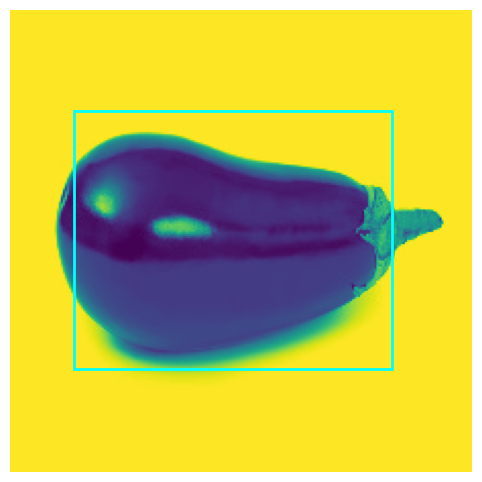

In [126]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
rect = patches.Rectangle(
    (pred_bbox[0], pred_bbox[1]),           # Bottom-left corner
    pred_bbox[2] - pred_bbox[0],            # Width
    pred_bbox[3] - pred_bbox[1],            # Height
    linewidth=2, edgecolor='cyan', facecolor='none'
)
ax.add_patch(rect)

# Remove axis and display
ax.axis('off')
plt.show()

1/1 [==============================] - 0s 16ms/step


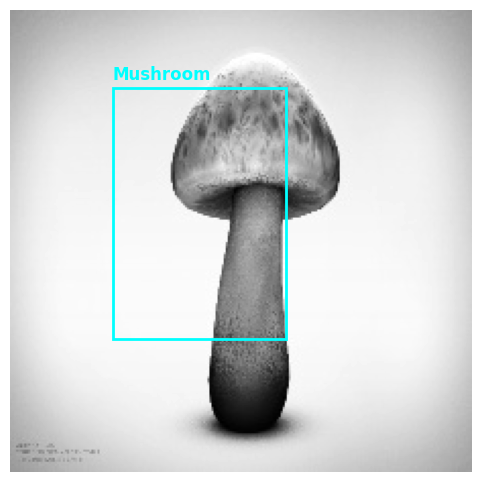

1/1 [==============================] - 0s 15ms/step


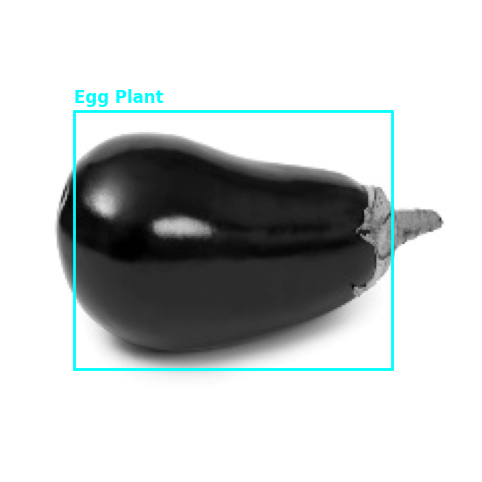

1/1 [==============================] - 0s 19ms/step


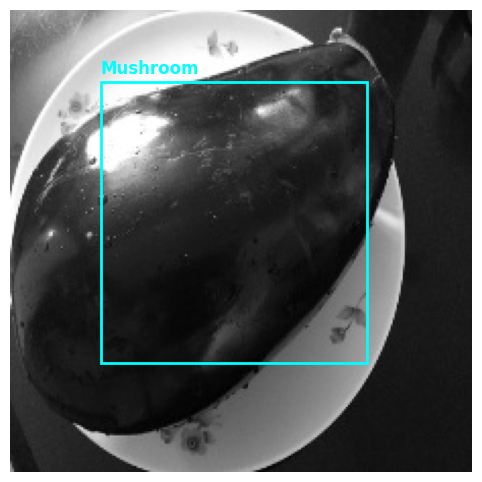

1/1 [==============================] - 0s 16ms/step


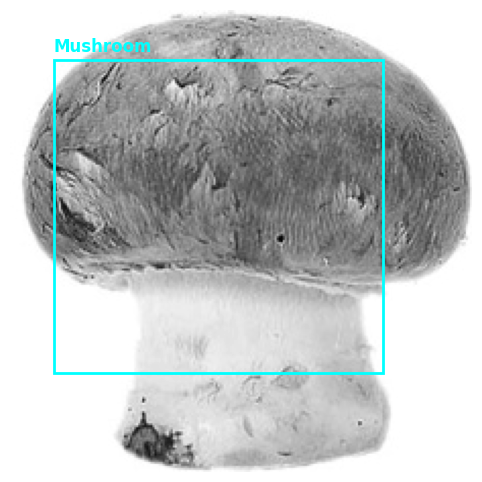

1/1 [==============================] - 0s 20ms/step


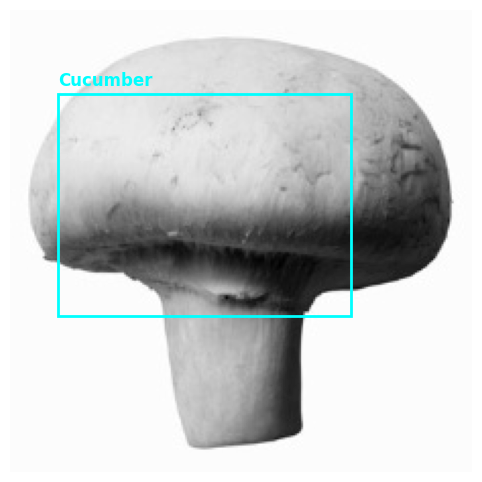

1/1 [==============================] - 0s 21ms/step


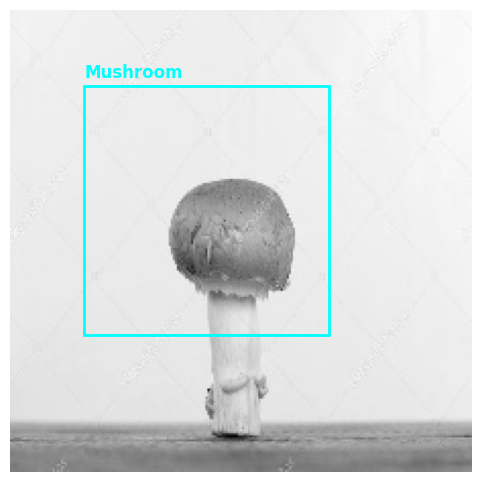

1/1 [==============================] - 0s 21ms/step


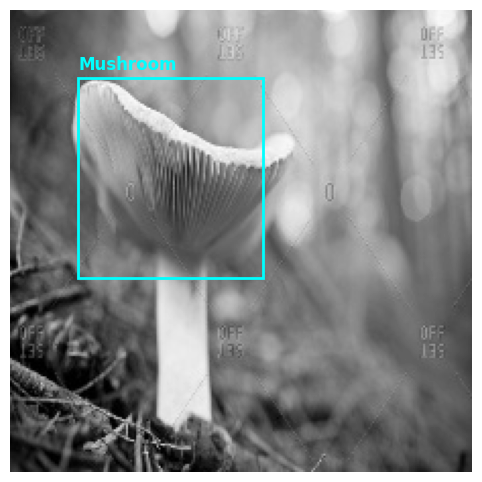

1/1 [==============================] - 0s 26ms/step


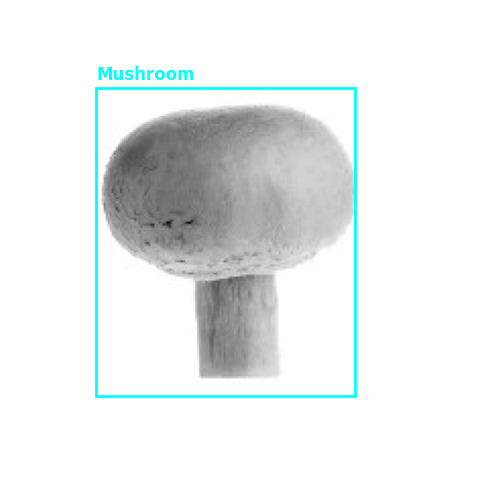

1/1 [==============================] - 0s 22ms/step


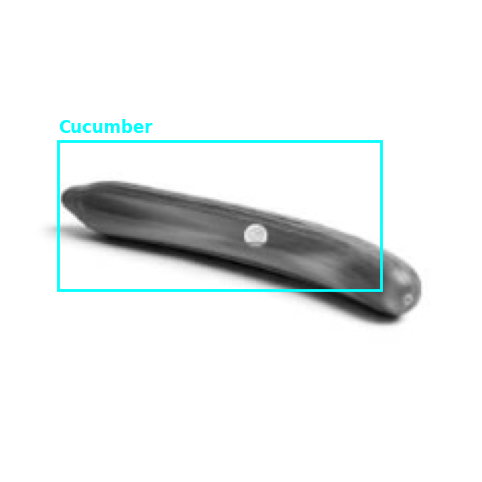

1/1 [==============================] - 0s 17ms/step


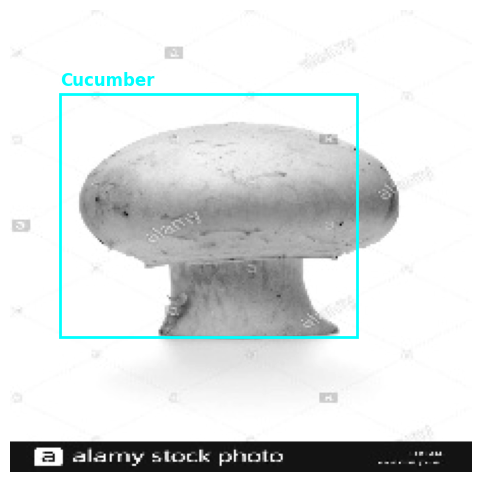

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Loop through the first 10 images in X_test
for i in range(10):
    image = X_test[i]  # Select the ith image from X_test
    img = image  # Keep the original image

    # Normalize and expand dimensions for prediction
    image = np.expand_dims(image, axis=0)  # Shape becomes (1, 227, 227, 1)

    # Make prediction
    predictions = model.predict(image)

    # Get predicted bounding box (ensure it's a list/array)
    pred_bbox = predictions[1]
    pred_bbox = pred_bbox.flatten()  # Flatten to 1D array

    # Denormalize the bounding box (multiply by image size if needed)
    pred_bbox = pred_bbox * [227, 227, 227, 227]  # Denormalize to pixel coordinates
    pred_bbox = pred_bbox.astype(int)  # Convert to integers

    # Extract the bounding box for this image
    pred_bbox = pred_bbox.tolist()  # Ensure it's a list of 4 integers

    # Get predicted class
    pred_class = np.argmax(predictions[0])

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img.squeeze(), cmap='gray')  # Display the image

    # Draw the bounding box
    rect = patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),           # Bottom-left corner
        pred_bbox[2] - pred_bbox[0],            # Width
        pred_bbox[3] - pred_bbox[1],            # Height
        linewidth=2, edgecolor='cyan', facecolor='none'
    )
    ax.add_patch(rect)

    # Add the class label text to the image
    class_labels = {1: 'Cucumber', 2: 'Egg Plant', 3: 'Mushroom'}
    pred_label = class_labels.get(pred_class, 'Unknown')
    ax.text(pred_bbox[0], pred_bbox[1] - 4, pred_label, color='cyan', fontsize=12, fontweight='bold')

    # Remove axis and display
    ax.axis('off')
    plt.show()